# Overview

For this project I evaluated a dataset of 20 attributes and 3333 rows containing SyraTel's churn metrics. I outline my process of identifying the top indicators of churn and creating machine learning model to predict whether or not a client will soon churn. I was able to create several machine learning classification models and compare their performance on unseen data to decide on a final predictive model that SyriaTel could deploy on their current client database. My final model utilized sklearn's Decision Tree Classifier.

# Business Problem

SyriaTel, a telecommunications company, is interested in reducing how much money is lost because of customers who don't stick around very long, that is, reducing their churn rate.

# Method

This objective will be achieved by first assessing feature importance on the below attributes and determining which tend to be the strongest predictors of churn. Secondly, I will apply these attributes to the final classification model to classify at clients who pose a risk of churning presently and in the future. The final step will ultimately be the deployment of a final model on existing clients database.

# Data Understanding

The data comes from SyriaTel and includes information about their customers. The dataset has customer's state of residence, telephone numbers and length of the account. There are columns indicating if the customer has an international plan and voicemail plan, how many voice mails they receive. The dataset includes how many minutes they spend talking, how many calls they make and how much they are charged during day, evening and night periods.

# Exploratory Data Analysis (EDA)

### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('./data/bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
df.shape

(3333, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [5]:
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

-  Attributes are not on the same scale, this may be a problem for models like K Nearest Neighbors, I can fix this by utilizing a StandardScaler or a MaxAbsScaler.
-  There are no missing values
-  A few of my columns look like they may have a dtype object.

In [6]:
# phone numbers and area code are private information and they may not have a large impact on the model
df = df.drop(columns = ["phone number", "area code"], axis = 1)
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [8]:
df['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

- Visualizing the churn rate

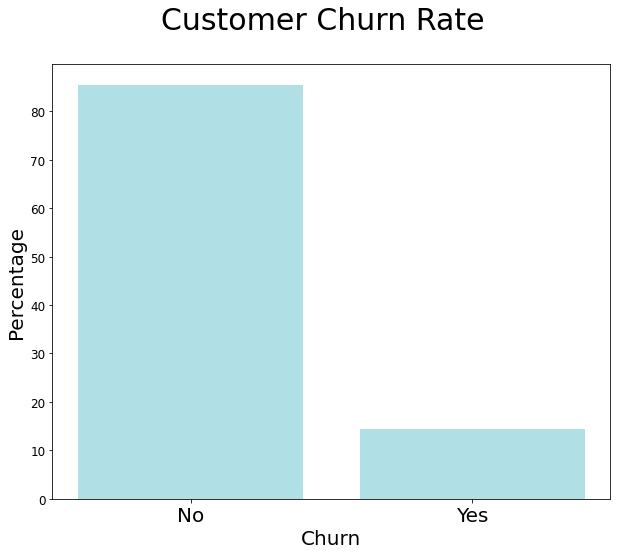

<Figure size 432x288 with 0 Axes>

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(x = df['churn'].unique(), height = round(df["churn"].value_counts(normalize=True)*100, 2), color = 'powderblue')
plt.xticks(ticks=[0,1], labels = ['No', 'Yes'], fontsize = 20)
plt.yticks(fontsize = 12)
ax.set_xlabel("Churn", fontsize = 20)
ax.set_ylabel("Percentage", fontsize = 20)
plt.suptitle('Customer Churn Rate', fontsize = 30)
plt.show()
plt.savefig('./images/Customer Churn Rate.png', dpi = 150)

In [10]:
# grouping states by their churn rates
states = df.groupby('state')['churn'].value_counts(normalize=True)
states = pd.DataFrame(states)
states.columns = ['percent']
grouped_states = states.reset_index()
grouped_states

,state,churn,percent
0,AK,False,0.942308
1,AK,True,0.057692
2,AL,False,0.900000
3,AL,True,0.100000
4,AR,False,0.800000
...,...,...,...
97,WI,True,0.089744
98,WV,False,0.905660
99,WV,True,0.094340
100,WY,False,0.883117


In [13]:
# This function creates a new column by add the specifed columns
def create(name, *cols):
    df[name] = sum(cols)

In [14]:
# Total domestic minutes for each customer.
create("total_domestic_minutes", 
        df["total day minutes"], 
        df["total eve minutes"], 
        df["total night minutes"])

# Total domestic calls for each customer.
create("total_domestic_calls", 
        df["total day calls"], 
        df["total eve calls"], 
        df["total night calls"])

# Total domestic charges for each customer.
create("total_domestic_charge", 
        df["total day charge"], 
        df["total eve charge"], 
        df["total night charge"])

# Total charges for each customer.
create("total_charge", 
        df["total_domestic_charge"], 
        df["total intl charge"])

df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,11.01,10.0,3,2.70,1,False,707.2,300,72.86,75.56
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,11.45,13.7,3,3.70,1,False,611.5,329,55.54,59.24
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,7.32,12.2,5,3.29,0,False,527.2,328,59.00,62.29
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,8.86,6.6,7,1.78,2,False,558.2,248,65.02,66.80
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,8.41,10.1,3,2.73,3,False,501.9,356,49.36,52.09


In [15]:
#churn rates for each state
states_churn_rate = grouped_states.loc[grouped_states['churn'] == True].sort_values("percent", ascending =False).reset_index().drop("index", axis =1)
states_churn_rate

#this cell assigns states to a high turn category.
#20% percent is alot of churn
high_churn = states_churn_rate.loc[states_churn_rate['percent'] >= .2]
high_churn_states = list(high_churn['state'])
high_churn_states

['NJ', 'CA', 'TX', 'MD', 'SC', 'MI', 'MS', 'NV', 'WA', 'ME', 'MT', 'AR']

In [16]:
#we wanted to find more evenness in the splits, so we split at 15%
med_churn = states_churn_rate.loc[(states_churn_rate['percent'] < .2) & (states_churn_rate['percent'] >= .15)]
med_churn_states = list(med_churn['state'])
med_churn_states

['KS', 'NY', 'MN', 'PA', 'MA', 'CT', 'NC', 'NH']

In [17]:
#finishing the "medium" split
medlow_churn = states_churn_rate.loc[(states_churn_rate['percent'] < .15) & (states_churn_rate['percent'] >= .1)]
medlow_churn_states = list(medlow_churn['state'])
medlow_churn_states

['GA',
 'DE',
 'OK',
 'OR',
 'UT',
 'CO',
 'KY',
 'SD',
 'OH',
 'FL',
 'IN',
 'ID',
 'WY',
 'MO',
 'VT',
 'AL']

In [18]:
low_churn = states_churn_rate.loc[states_churn_rate['percent'] < .1]
low_churn_states = list(low_churn['state'])
low_churn_states

['NM',
 'ND',
 'WV',
 'TN',
 'DC',
 'RI',
 'WI',
 'IL',
 'NE',
 'LA',
 'IA',
 'VA',
 'AZ',
 'AK',
 'HI']

In [19]:
# The function below assigns states to high, medium, medium-low and low churn rate categories
def categorize(state):
    if state in high_churn_states:
        state = "high"
    elif state in med_churn_states:
        state = "med"
    elif state in medlow_churn_states:
        state = "med-low"
    else:
        state ="low"
    return state

In [20]:
# The function below applies the categorize function to a new column named state,
#assigns the modified column to  a new category called 'churn_rate'
def competition(dataframe):
    df["churn_rate"] = df["state"].apply(categorize)
    return df

In [21]:
competition(df)

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,False,707.2,300,72.86,75.56,med
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,False,611.5,329,55.54,59.24,med-low
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,False,527.2,328,59.00,62.29,high
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,False,558.2,248,65.02,66.80,med-low
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,False,501.9,356,49.36,52.09,med-low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,26.55,215.5,126,...,9.9,6,2.67,2,False,650.8,286,57.43,60.10,low
3329,WV,68,no,no,0,231.1,57,39.29,153.4,55,...,9.6,4,2.59,3,False,575.8,235,60.94,63.53,low
3330,RI,28,no,no,0,180.8,109,30.74,288.8,58,...,14.1,6,3.81,2,False,661.5,258,63.93,67.74,low
3331,CT,184,yes,no,0,213.8,105,36.35,159.6,84,...,5.0,10,1.35,2,False,512.6,326,56.18,57.53,med


In [22]:
df['customer service calls'].describe()

count    3333.000000
mean        1.562856
std         1.315491
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: customer service calls, dtype: float64

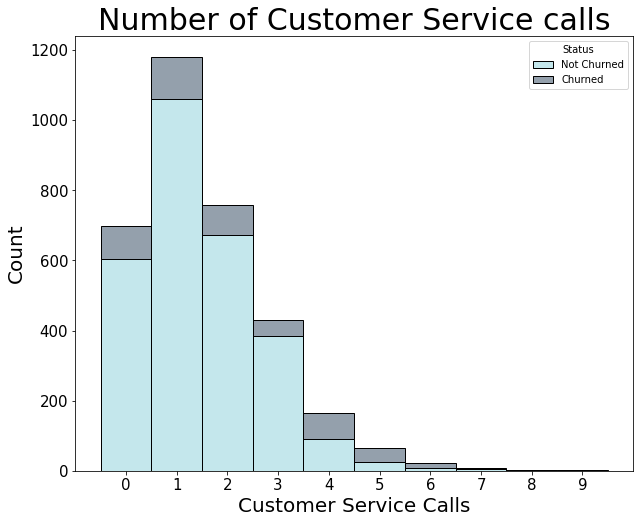

In [24]:
fig,ax = plt.subplots(figsize=(10,8))

bins = np.arange(11) - 0.5

ax = sns.histplot(
    df,
    x='customer service calls',
    hue='churn',
    multiple='stack',
    hue_order=[1,0],
    bins=bins,
    palette=['slategrey', 'powderblue']

)

ax.set_title('Number of Customer Service calls', fontsize = 30)
ax.set_xlabel("Customer Service Calls", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(range(10), fontsize = 15)
plt.xlim([-1, 10])
plt.savefig('./images/Number of Customer Service Calls.png', dpi = 150)

ax.legend(title= "Status", labels = ["Not Churned", 'Churned'])

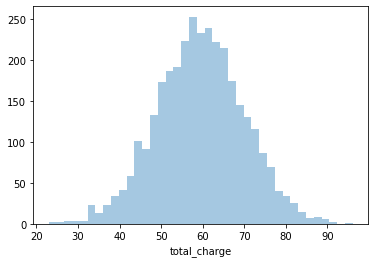

In [27]:
sns.distplot(df['total_charge'], kde=False)
plt.show()

There is a normal distribution for total charge, most clients spend $50-70, and the values are symetrical on either side of the curve.

In [30]:
# create a new data frame with only the clients who churned
df_churned = df[df.churn != False]
df_churned.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
10,IN,65,no,no,0,129.1,137,21.95,228.5,83,...,12.7,6,3.43,4,True,566.4,331,50.77,54.20,med-low
15,NY,161,no,no,0,332.9,67,56.59,317.8,97,...,5.4,9,1.46,4,True,811.3,292,90.83,92.29,med
21,CO,77,no,no,0,62.4,89,10.61,169.9,121,...,5.7,6,1.54,5,True,441.9,274,34.48,36.02,med-low
33,AZ,12,no,no,0,249.6,118,42.43,252.4,119,...,11.8,3,3.19,1,True,782.2,327,76.49,79.68,low
41,MD,135,yes,yes,41,173.1,85,29.43,203.9,107,...,14.6,15,3.94,0,True,499.2,270,52.26,56.20,high


In [32]:
# create a new column for clients who did or did not call customer service on both dataframes
df_churned['called_cs'] = df_churned['customer service calls'] >=1
df['called_cs'] = df['customer service calls'] >=1

display(df.head())
display(df_churned.head())

<ipython-input-32-a37539772035>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_churned['called_cs'] = df_churned['customer service calls'] >=1


,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate,called_cs
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,3,2.70,1,False,707.2,300,72.86,75.56,med,True
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,3,3.70,1,False,611.5,329,55.54,59.24,med-low,True
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,5,3.29,0,False,527.2,328,59.00,62.29,high,False
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,7,1.78,2,False,558.2,248,65.02,66.80,med-low,True
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,3,2.73,3,False,501.9,356,49.36,52.09,med-low,True


,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate,called_cs
10,IN,65,no,no,0,129.1,137,21.95,228.5,83,...,6,3.43,4,True,566.4,331,50.77,54.20,med-low,True
15,NY,161,no,no,0,332.9,67,56.59,317.8,97,...,9,1.46,4,True,811.3,292,90.83,92.29,med,True
21,CO,77,no,no,0,62.4,89,10.61,169.9,121,...,6,1.54,5,True,441.9,274,34.48,36.02,med-low,True
33,AZ,12,no,no,0,249.6,118,42.43,252.4,119,...,3,3.19,1,True,782.2,327,76.49,79.68,low,True
41,MD,135,yes,yes,41,173.1,85,29.43,203.9,107,...,15,3.94,0,True,499.2,270,52.26,56.20,high,False


In [33]:
sum(df_churned['called_cs'] == True) / len(df_churned['called_cs'])

0.8095238095238095

In [34]:
sum(df['called_cs'] == True) / len(df['called_cs'])

0.7908790879087909

79% of all clients have made one or more customer service calls and 81% of all churned clients made one call or more. These numbers are fairly proportionate, across all clients and churned clients. I would still like to break this down further by checking if there is a certain number of calls that may be a strong indicator of churn.

In [36]:
# calculate the churn rate for each number of phone calls
churn_by_cs_calls = []

for x in range(0,10):
    churn_by_cs_calls.append(round(sum(df_churned['customer service calls'] == x) / 
                             sum(df['customer service calls'] == x) * 100, 0))
churn_by_cs_calls

[13.0, 10.0, 11.0, 10.0, 46.0, 61.0, 64.0, 56.0, 50.0, 100.0]

In [38]:
# asses churn rate by one additional call or more. i.e. churn rate for 1+, 2+, 3+, etc.
churn_by_cs_calls_range = []

for x in range(0,10):
    churn_by_cs_calls_range.append(round(sum(df_churned['customer service calls'] >= x) / 
                             sum(df['customer service calls'] >= x) * 100, 0))
churn_by_cs_calls_range

[14.0, 15.0, 18.0, 26.0, 52.0, 61.0, 63.0, 62.0, 75.0, 100.0]

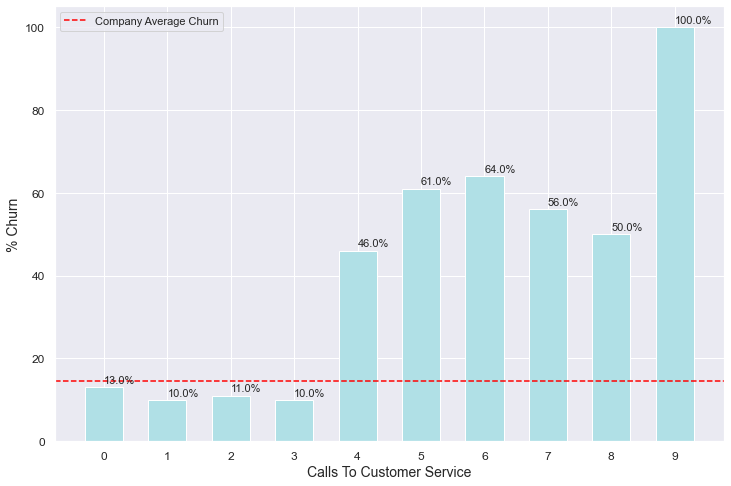

In [41]:
# plot churn for each additional phone call
sns.set()
x = range(0,10)
plt.figure(figsize=(12,8))
plt.bar(x=x, 
        height=churn_by_cs_calls,
        width = 0.6, 
        tick_label=x, 
        color='powderblue')

for index,data in enumerate(churn_by_cs_calls):
    plt.text(x=index , 
             y =data+1 , 
             s=f"{data}%" , 
             fontdict=dict(fontsize=11)) # plot percentages over bars

plt.axhline(14.5, label='Company Average Churn', ls='--', color='red') # plot average company churn
# assign x and y labels
plt.ylabel('% Churn', size=14)
plt.xlabel('Calls To Customer Service', size=14)
# increase size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# add a legend
plt.legend()
# show and save the image
fig1 = plt.gcf()
plt.show()
fig1.savefig('./images/Average churn.png', dpi=100)

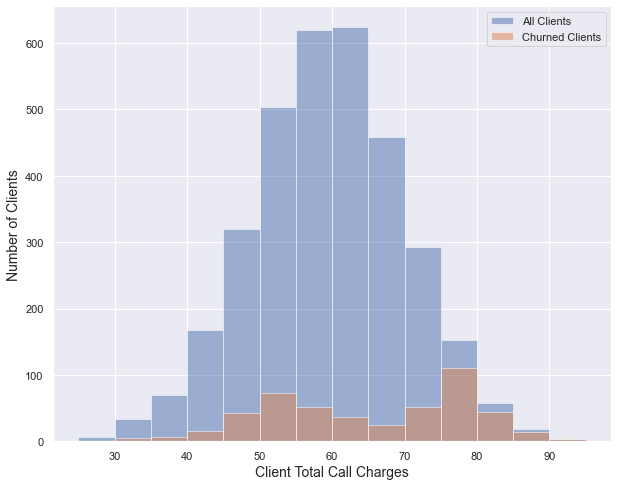

In [45]:
# plot the proportion of churned clients by charges against the total number 
# of clients within each price range
plt.figure(figsize=(10,8))
plt.hist(
         df['total_charge'], 
         bins=range(25, 100, 5), 
         alpha=0.5, 
         label="All Clients"
)
plt.hist(
         df_churned['total_charge'], 
         bins=range(25, 100, 5), 
         alpha=0.5, 
         label="Churned Clients"
)

plt.legend()

plt.xlabel('Client Total Call Charges', size=14)
plt.ylabel('Number of Clients', size=14)

fig4 = plt.gcf()
plt.show()
fig4.savefig('./images/proportions.png', dpi=150)

In [46]:
# calculate churn rate for each bin in the double histogram above
counts10, _ =  np.histogram(df['total_charge'], bins=range(20, 100, 5))
counts11, _ =  np.histogram(df_churned['total_charge'], bins=range(20, 100, 5))
counts11 / counts10

array([0.5       , 0.14285714, 0.15151515, 0.1       , 0.08928571,
       0.134375  , 0.14484127, 0.08387097, 0.05769231, 0.05458515,
       0.17406143, 0.7254902 , 0.75862069, 0.77777778, 1.        ])

In [47]:
# calculate churn rate for day charges by price bins
counts12, _ =  np.histogram(df['total day charge'], bins=range(20, 70, 5))
counts13, _ =  np.histogram(df_churned['total day charge'], bins=range(20,70,5))
day_change = list(counts13 / counts12)
x2 = [25,30,35,40,45,50,60]
day_change

<ipython-input-47-cac60c6d37b4>:4: RuntimeWarning: invalid value encountered in true_divide
  day_change = list(counts13 / counts12)


[0.11860940695296524,
 0.11499272197962154,
 0.06119402985074627,
 0.10564663023679417,
 0.23529411764705882,
 0.5460526315789473,
 0.6739130434782609,
 1.0,
 nan]

In [49]:
# converting decimals to percentages
day_change = [11.86, 11.50, 6.12, 10.56, 23.53, 54.61, 74.14]

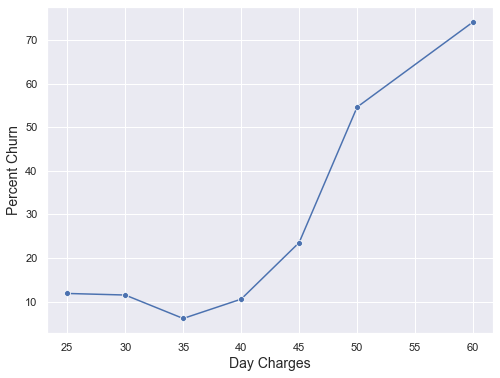

In [51]:
# plot churn rate for each $5 increase in day charges
plt.figure(figsize=(8,6))
sns.lineplot(x=x2, y=day_change, marker="o")
plt.xlabel('Day Charges', size=14)
plt.ylabel('Percent Churn', size=14)
fig5 = plt.gcf()
plt.show()
fig5.savefig('./images/Churn rate against charges.png', dpi=100)

# Modelling

In [55]:
# The function below returns the evaluation metrics of a model
def evaluate(estimator, X_trained, X_tested, y_trained, y_tested, roc_auc = 'skip'):
    trained_preds = estimator.predict(X_trained)
    tested_preds = estimator.predict(X_tested)
    
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_trained)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_trained)[:, 1] 
        test_out = estimator.predict_proba(X_tested)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")
        
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_trained, trained_preds)}")
    print(f"Train Precision: {precision_score(y_trained, trained_preds)}")
    print(f"Train Recall: {recall_score(y_trained, trained_preds)}")
    print(f"Train F1-Score: {f1_score(y_trained, trained_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_trained, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_tested, tested_preds)}")
    print(f"Test Precision: {precision_score(y_tested, tested_preds)}")
    print(f"Test Recall: {recall_score(y_tested, tested_preds)}")
    print(f"Test F1-Score: {f1_score(y_tested, tested_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_tested, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_tested, y_tested, values_format='.5g', cmap=plt.cm.Blues)

In [56]:
#splits our data set to features and the target "churn"
X = df.drop(["churn"], axis = 1)
y= df["churn"]
#this seed will ensure we use the same random_state in all of our modeling
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.25, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.1, random_state=seed)

In [57]:
X_train.shape

(2249, 24)

In [58]:
X_test.shape

(250, 24)

In [59]:
# organize columns for the pipeline
num_cols = []
ohe_cols = []

for c in X_train.columns:
    if X_train[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        ohe_cols.append(c)
print('Numerical columns')        
print(num_cols)
print()
print('Categorical columns')
print(ohe_cols)

Numerical columns
['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'total_domestic_minutes', 'total_domestic_calls', 'total_domestic_charge', 'total_charge']

Categorical columns
['state', 'international plan', 'voice mail plan', 'churn_rate', 'called_cs']


In [60]:
# Takes all numerical variables and imputes them
nums = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

#Takes all categorical variables and OneHotEncodes them
ohe = Pipeline(steps=[
    ("ohe_encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

In [61]:
#builds our preprocessor step using a ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", nums, num_cols),
        ("ohe", ohe, ohe_cols)
    ])
preprocess.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['account length', 'number vmail messages',
                                  'total day minutes', 'total day calls',
                                  'total day charge', 'total eve minutes',
                                  'total eve calls', 'total eve charge',
                                  'total night minutes', 'total night calls',
                                  'total night charge', 'total intl minutes',
                                  'total intl calls', 'total intl charge',
                                  'customer service calls',
                                  'total_domestic_minutes',
                                  'total_domestic_calls',
                                  'total_domestic_charge', 'total_charge']),
                       

In [62]:
# Create an instance object of Pipeline() 
logreg = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ("scaler", MaxAbsScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Fit the training data on to the pipeline
logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

Training Scores:
Train Accuracy: 0.8034682080924855
Train Precision: 0.4025974025974026
Train Recall: 0.7701863354037267
Train F1-Score: 0.5287846481876333
ROC-AUC: 0.850992918545546
**********
Testing Scores:
Test Accuracy: 0.788
Test Precision: 0.3559322033898305
Test Recall: 0.5833333333333334
Test F1-Score: 0.4421052631578947
ROC-AUC: 0.8082814122533748


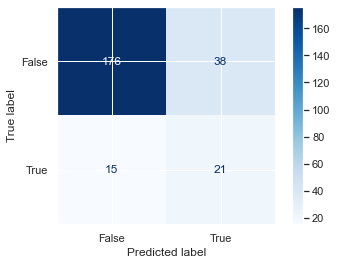

In [63]:
evaluate(logreg, 
         X_train, X_test, 
         y_train, y_test, 
         roc_auc='proba')

In [64]:
tuned_logreg = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ("scaler", MaxAbsScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

In [65]:
# Adjusting the max iterations, penalty, the regulation power 
# and using a liblinear solver due to the choices in penalty and the size of the data set
param_grid = {
    'classifier__max_iter': [1000, 10000, 100000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [1, 5, 10, 100],
    'classifier__solver': ["liblinear"]
}

grid = GridSearchCV(tuned_logreg, param_grid)

output = grid.fit(X_train, y_train)

In [66]:
# Getting the best hyperparameters based on the grid search
output.best_params_

{'classifier__C': 1,
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

Training Scores:
Train Accuracy: 0.8039128501556247
Train Precision: 0.4032520325203252
Train Recall: 0.7701863354037267
Train F1-Score: 0.5293489861259338
ROC-AUC: 0.8513684258026669
**********
Testing Scores:
Test Accuracy: 0.796
Test Precision: 0.3728813559322034
Test Recall: 0.6111111111111112
Test F1-Score: 0.4631578947368421
ROC-AUC: 0.8086708203530634


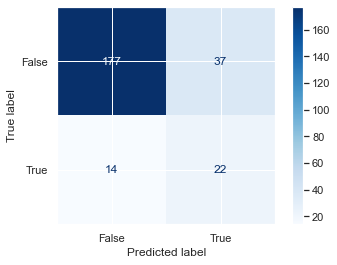

In [67]:
evaluate(output.best_estimator_, 
         X_train, X_test, 
         y_train, y_test, 
         roc_auc='proba')

# Decision Tree

In [68]:
#Decision trees do not need scaling because they are nonparametric
dtree = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

dtree.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [69]:
cross_validate(dtree, X_train, y_train, return_train_score = True, scoring="recall")

{'fit_time': array([0.36025071, 0.16278505, 0.1562326 , 0.14611912, 0.15678239]),
 'score_time': array([0.03440428, 0.        , 0.        , 0.        , 0.01779866]),
 'test_score': array([0.78125   , 0.890625  , 0.81538462, 0.89230769, 0.859375  ]),
 'train_score': array([1., 1., 1., 1., 1.])}

Training Scores:
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1-Score: 1.0
ROC-AUC: 1.0
**********
Testing Scores:
Test Accuracy: 0.948
Test Precision: 0.8285714285714286
Test Recall: 0.8055555555555556
Test F1-Score: 0.8169014084507044
ROC-AUC: 0.8887590861889928


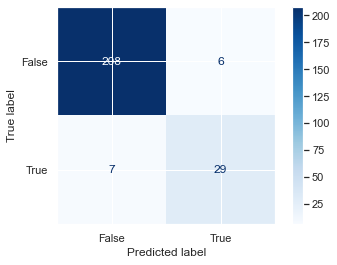

In [70]:
evaluate(dtree,
         X_train, X_test,
         y_train, y_test,
         roc_auc='proba')

In [71]:
dtree_tuned = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

In [72]:
param_grid = {
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__min_samples_split": [2, 3, 5,10],
    "classifier__min_samples_leaf": [2, 3, 5,10]
}

grid_dtree = GridSearchCV(dtree_tuned, param_grid)

output = grid_dtree.fit(X_train, y_train)

In [73]:
output.best_params_

{'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2}

Training Scores:
Train Accuracy: 0.9764339706536238
Train Precision: 0.996309963099631
Train Recall: 0.8385093167701864
Train F1-Score: 0.9106239460370995
ROC-AUC: 0.9392814434950217
**********
Testing Scores:
Test Accuracy: 0.968
Test Precision: 0.9666666666666667
Test Recall: 0.8055555555555556
Test F1-Score: 0.8787878787878789
ROC-AUC: 0.9069963655244029


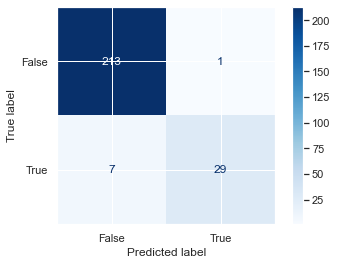

In [74]:
evaluate(output.best_estimator_,
         X_train, X_test,
         y_train, y_test,
         roc_auc='proba')

In [75]:
X = df.drop(["churn"],axis = 1)
y= df["churn"]
seed = 42

#10% of my data  held for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.2, random_state=seed)

In [76]:
final_dtree = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(max_depth = 5,
                                          min_samples_split=2,
                                          min_samples_leaf=2,
                                          random_state=seed))
])
final_dtree.fit(X_use, y_use)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

Training Scores:
Train Accuracy: 0.976325441813938
Train Precision: 0.9890710382513661
Train Recall: 0.8438228438228438
Train F1-Score: 0.910691823899371
ROC-AUC: 0.9399744224646949
**********
Testing Scores:
Test Accuracy: 0.9730538922155688
Test Precision: 1.0
Test Recall: 0.8333333333333334
Test F1-Score: 0.9090909090909091
ROC-AUC: 0.936441798941799


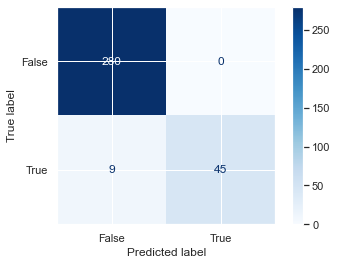

In [77]:
evaluate(final_dtree, X_use, X_hold, y_use, y_hold, roc_auc='proba')

# Feature Importance

In [78]:
# size of the training data that has been held out
final_dtree["preprocess"].fit_transform(X_use).shape

(2999, 80)

In [79]:
pd.DataFrame(final_dtree["preprocess"].fit_transform(X_train)).shape

(2399, 80)

In [80]:
pd.DataFrame(final_dtree["preprocess"].fit_transform(X_train)).head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,145.0,0.0,199.2,124.0,33.86,126.0,86.0,10.71,289.2,135.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,179.0,0.0,170.7,54.0,29.02,191.1,108.0,16.24,214.6,107.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,98.0,0.0,126.3,102.0,21.47,166.8,85.0,14.18,187.8,135.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,10.0,0.0,222.2,127.0,37.77,153.1,125.0,13.01,227.4,80.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,66.0,36.0,106.7,76.0,18.14,209.8,77.0,17.83,190.4,117.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [81]:
#raw feature importances
final_dtree['classifier'].feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.00043856,
       0.00158743, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03858705, 0.02384175, 0.0004478 , 0.21093487,
       0.        , 0.        , 0.        , 0.33613922, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00368791, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.28827716, 0.        , 0.        , 0.04265221, 0.05340

In [82]:
#list of numerical features in our model
num_cols_finaldtree = final_dtree['preprocess'].transformers_[0][2]
num_cols_finaldtree

['account length',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'total_domestic_minutes',
 'total_domestic_calls',
 'total_domestic_charge',
 'total_charge']

In [83]:
#list of categorical features in our model
transformed_ohe_cols = final_dtree['preprocess'].transformers_[1][1]['ohe_encoder'].get_feature_names(ohe_cols)
transformed_ohe_cols

array(['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV',
       'state_WY', 'international plan_no', 'international plan_yes',
       'voice mail plan_no', 'voice mail plan_yes', 'churn_rate_high',
       'churn_rate_low', 'churn_rate_med', 'churn_rate_med-low',
       'called_cs_False', 'called_cs_True'], dtype=object)

In [84]:
final_cols =[*num_cols_finaldtree, *transformed_ohe_cols]
final_cols

['account length',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'total_domestic_minutes',
 'total_domestic_calls',
 'total_domestic_charge',
 'total_charge',
 'state_AK',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',


In [85]:
# combining features and their weights(feature_importances) into a dataframe
features = pd.DataFrame.from_dict(dict(zip(final_cols, final_dtree['classifier'].feature_importances_)), 
                       orient='index').sort_values(by=0, ascending=False).head(10).reset_index()
features

,index,0
0,total_charge,0.336139
1,international plan_no,0.288277
2,customer service calls,0.210935
3,churn_rate_high,0.053406
4,voice mail plan_yes,0.042652
5,total intl minutes,0.038587
6,total intl calls,0.023842
7,state_LA,0.003688
8,total eve minutes,0.001587
9,total intl charge,0.000448


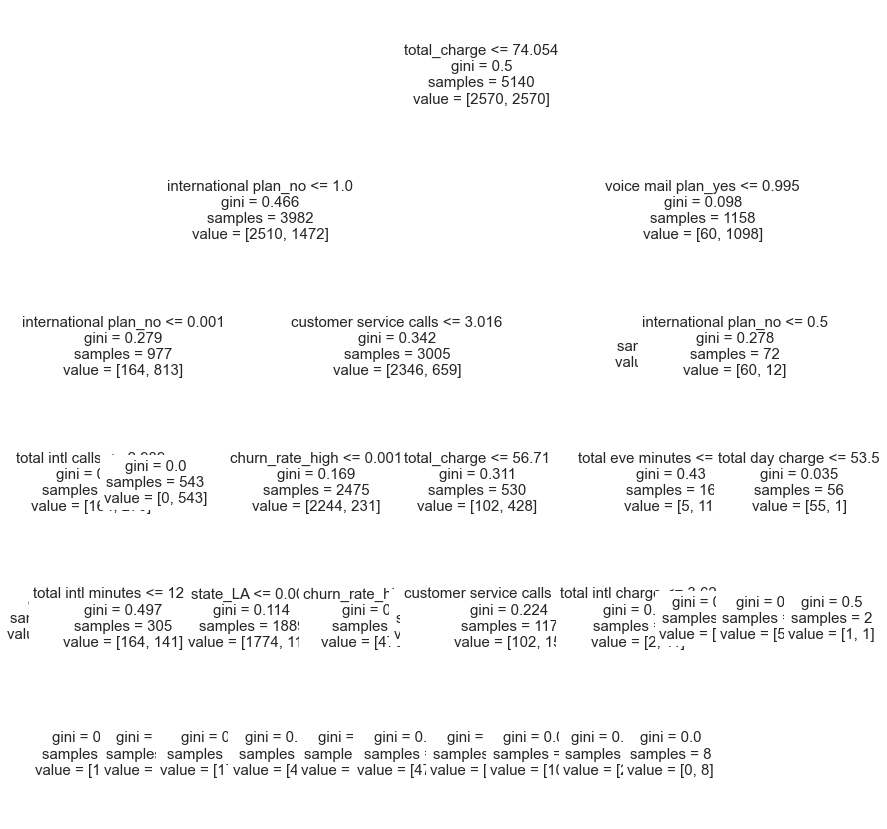

In [88]:
#visualizes the tree
fig, ax = plt.subplots(figsize=(15,15))
plot_tree(final_dtree["classifier"], feature_names=final_cols, fontsize=15)
plt.show()